# Phase-Amplitude Coupling (PAC)

Written by: David C.C. Lu

This notebook describes the concept of phase-amplitude coupling used in my research. Many of the concept can be found in Tort el. 2011.

Phase-Amplitude Coupling (PAC) is a more interested form of cross frequency coupling (CFC) in brain rhythms. Many studies have found PAC in the local field potentials (LFP) of patients with Parkinson's disease (PD). The goal is to develop a framework for computing/quantify PAC using Python. [Brain Storm](http://neuroimage.usc.edu/brainstorm/Tutorials/TutPac) have simply describe and illustrate the overview and one of several techniques used to quantify PAC.

There are several Python-based tools already existed out there for qunatifying PAC. i.e., [`pacpy`](https://github.com/voytekresearch/pacpy) and [`pactools`](https://github.com/pactools/pactools). The goal here is not to duplicate these existing work, but to develop another framework that has the flexibility to use custom filtering tools, such that faster computation of PAC comodulogram can be implemented and used for real time application. Because the techniques and filters used to obtain the analytical signals are different than `pacpy` and `pactools`, the calculated PAC results are expected to be different.

# Overview

* [Generate a Test Signal](#gen_test_signal)
* [Filtering the Signal](#filter_data)
* [Computing PAC](#pac_compute)
* [Appendix 1: Insights on Instantaneous Phases](#appendix1)
* [References](#references)

In [1]:
save_plot = False

# Import all system modules
import os
import sys
import time

# Import all scientific modules
%matplotlib inline

import numpy as np
from scipy.stats import entropy

from pytf import FilterBank

import mne
from mspacman.algorithm.pac_ import (pad, mrpad, polar, pac_mvl, pac_hr, pac_mi)

from mspacman.generator import (noise, simulate_pac)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

<a id=gen_test_signal></a>
# Generate a Test Signal

Review this [notebook on PAC generator](Notes_PAC_Generator.ipynb) to understand how signals are generated, and how the data are bundled into `'pacgen_raw.fif'`.

In [2]:
data_path = os.getcwd()
fname = os.path.join(data_path, 'data', 'pacgen_raw.fif')

raw = mne.io.read_raw_fif(fname, preload=True)

Opening raw data file /Users/davidlu/Developer/PhD Projects/notes_mspacman/data/pacgen_raw.fif...
Isotrak not found
    Range : 0 ... 131071 =      0.000 ...     8.000 secs
Ready.
Reading 0 ... 131071  =      0.000 ...     8.000 secs...


In [3]:
dat = raw.get_data()
Nch, Nsamp = dat.shape
fs = int(raw.info['sfreq'])

white = noise.white(Nsamp)
pink = noise.pink(Nsamp)

x = raw.get_data()

x_obj = np.zeros((4,), dtype=np.object)
for i in range(4):
    x_obj[i] = x[11*i:11*(i+1), :]

<a id=pac_compute></a>
# Computing PAC

This section focuses on computing PAC of a simulated signal generated from methods described in another [notebook on PAC generator](Notes_PAC_Generator.ipynb).

As discussed in [[1]](#ref1), there are many ways to quantify PAC. In the figure [below](#pac_plot), we will only be showing mean vector length (MVL) from polar coordinates, and modulation index (MI) from phase-amplitude distribution. The comodulogram shown in Fig. D is PAC quantified with MI.

In [4]:
# Simulation Parameters
# -----------------------------------------
# Select Channel
# There are 11 channels used in this data.
# Play around to see what changes. (0-10)
# -----------------------------------------
case = 2
ch = 5
decimate_by = 20
add_noise = False

fpsize = 20
fasize = 15
bw_p = 3
bw_a = 50

foi_p = (4, 50)
foi_a = (60, 200)

In [5]:
# Select signal to compute PAC on
x_ = x_obj[case].copy()
if add_noise:
    x_ += white
    x_ += pink

# First get the phase-giving and amplitude-enveloping signals for PAC
lo = FilterBank(binsize=2**14, freq_bands=np.asarray([(16-10, 16+10)]), order=2**14, sample_rate=fs, decimate_by=decimate_by, hilbert=True)
hi = FilterBank(binsize=2**14, freq_bands=np.asarray([(130-30, 130+30)]), order=2**14, sample_rate=fs, decimate_by=decimate_by, hilbert=True)

x_lo = lo.analysis(x_, window='hanning')
x_hi = hi.analysis(x_, window='hanning')

ang, amp = np.angle(x_lo), np.abs(x_hi)

# Get the phase-giving and amplitude-enveloping signals for comodulogram
fp = np.linspace(foi_p[0], foi_p[1], fpsize)
fa = np.linspace(foi_a[0], foi_a[1], fasize)

fois_lo = np.asarray([(f - bw_p, f + bw_p) for f in fp])
fois_hi = np.asarray([(f - bw_a, f + bw_a) for f in fa])

los = FilterBank(binsize=2**14, freq_bands=fois_lo, order=2**12, sample_rate=fs, decimate_by=decimate_by, hilbert=True)
his = FilterBank(binsize=2**14, freq_bands=fois_hi, order=2**12, sample_rate=fs, decimate_by=decimate_by, hilbert=True)

x_los = los.analysis(x_, window='hanning')
x_his = his.analysis(x_, window='hanning')

angs, amps = np.angle(x_los), np.abs(x_his)

# Compute PAC
t_ = np.linspace(0, Nsamp//fs, x_lo.shape[-1])

# phase-amplitude distribution (pad)
pd = pad(ang, amp, nbins=10)
pds = pad(angs, amps, nbins=10)
# phase-amplitude polar coordinates
print(ang.shape, amp.shape)
z = polar(ang, amp)[:,0,0,int(fs*.5/decimate_by):-int(fs*.5/decimate_by)]

mi = pac_mi(pd)
mis = pac_mi(pds)

print(pd.shape, ang.shape, amp.shape)
print(mi.shape, mis.shape, z.shape)

INFO:<class 'pytf.filter.filterbank.FilterBank'>:Creating the FilterBank class.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Created the prototype filter.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Initialized FilterBank.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Creating the FilterBank class.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Created the prototype filter.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Initialized FilterBank.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Creating the FilterBank class.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Created the prototype filter.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Initialized FilterBank.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Creating the FilterBank class.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Created the prototype filter.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Initialized FilterBank.


(11, 1, 6553) (11, 1, 6553)
(11, 1, 1, 10) (11, 1, 6553) (11, 1, 6553)
(11, 1, 1) (11, 20, 15) (11, 5735)


<a id=pac_plot></a>
# Plot Phase-Amplitude Coupling (PAC)

/Users/davidlu/.virtualenvs/py-phd/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


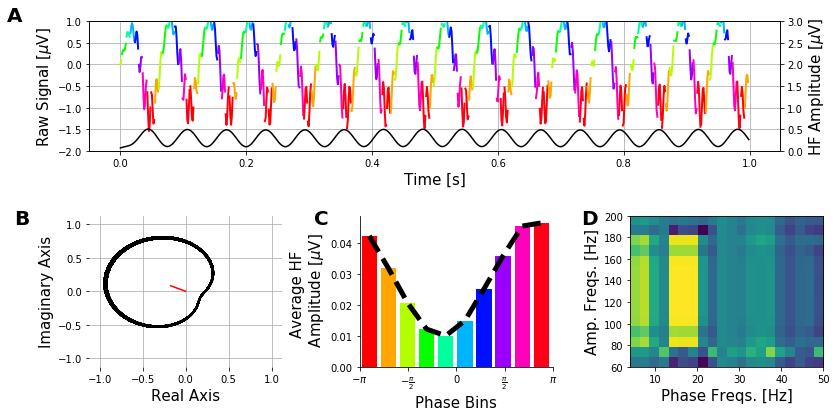

In [6]:
import matplotlib.patches as patches

###########################################
binsize = pd.shape[-1]
colors = plt.get_cmap('hsv')(np.linspace(0,1,binsize))

bin_centers = np.linspace(-np.pi, np.pi, binsize+1)
bin_centers2 = np.linspace(-np.pi, np.pi-np.pi/50, binsize+1) + np.pi/10

# Prepare Plots
fig_pac = plt.figure(figsize=(12,6))
gs1_pac = GridSpec(1, 1)
gs2_pac = GridSpec(1, 3)

gs1_pac.update(left=0.1, right=0.9, top=.9, bottom=.6, hspace=.01)
gs2_pac.update(left=0.1, right=0.95, top=.45, bottom=.1, hspace=.01, wspace=.4)

ax1_pac = [0, 1, 2, 3]
ax1_pac[0] = plt.subplot(gs1_pac[:, :])
ax1_pac[1] = plt.subplot(gs2_pac[:, 0])
ax1_pac[2] = plt.subplot(gs2_pac[:, 1])
ax1_pac[3] = plt.subplot(gs2_pac[:, 2])

# Plot Data
ax1_paca = ax1_pac[0].twinx()
for ix, b in enumerate(bin_centers[:-1]):
    tmp = np.logical_and(ang[ch,0,:int(fs//decimate_by)]>=bin_centers[ix], ang[ch,0,:int(fs//decimate_by)]<bin_centers[ix+1])
    tmp2 = np.zeros(tmp.size) * np.nan
    tmp2[np.nonzero(tmp)] = tmp[np.nonzero(tmp)]
    ax1_pac[0].plot(t_[:int(fs//decimate_by)]*tmp2, (x_lo[ch,0,:int(fs//decimate_by)]*tmp2+x_hi[ch,0,:int(fs//decimate_by)]*tmp2).real, c=colors[ix], lw=2)

ax1_paca.plot(t_[:int(fs//decimate_by)], amp[ch,0,:int(fs//decimate_by)], 'k')

ax1_pac[1].plot(z[ch,:].real,z[ch,:].imag, 'k')
ax1_pac[1].plot([0,z[ch,:].real.mean()], [0,z[ch,:].imag.mean()], color='r')

ax1_pac[2].plot(bin_centers2[:-1], pd[ch,0,0,:], c='k', ls='--', lw=5)
for ix, b in enumerate(bin_centers[:-1]):
    tmp = np.ones(pd[ch,0,0,:].shape) * np.nan
    tmp[ix] = pd[ch,0,0,ix]
    ax1_pac[2].bar(bin_centers2[:-1], tmp, color=colors[ix], width=.5)

ax1_pac[3].imshow(mis[ch,:,:].T, origin='lower', interpolation='nearest',
                                  norm=LogNorm(vmin=mis.min(), vmax=mis.max()),
                                  extent=[fp[0],fp[-1],fa[0],fa[-1]], aspect='auto')

# Plot Annotation
ax1_pac[0].text(-0.18, 1, 'A', fontsize=20, weight='bold')
ax1_pac[1].text(-2, 1, 'B', fontsize=20, weight='bold')
ax1_pac[1].text(1.5, 1, 'C', fontsize=20, weight='bold')
ax1_pac[1].text(4.6, 1, 'D', fontsize=20, weight='bold')

# Plot Properties
ax1_pac[0].set_ylim([-2,1])
ax1_pac[0].set_xlabel('Time [s]', fontsize=15)
ax1_pac[0].set_ylabel('Raw Signal [$\mu$V]', fontsize=15)
ax1_pac[0].grid('on')
ax1_paca.set_ylabel('HF Amplitude [$\mu$V]', fontsize=15)
ax1_paca.set_ylim([0,3])

ax1_pac[1].set_xlabel('Real Axis', fontsize=15)
ax1_pac[1].set_ylabel('Imaginary Axis', fontsize=15)
ax1_pac[1].grid('on')
xmax = np.ceil(np.max(z[ch,:].real)*10)/10
xmin = np.ceil(np.min(z[ch,:].real)*10)/10
ymax = np.ceil(np.max(z[ch,:].imag)*10)/10
ymin = np.ceil(np.min(z[ch,:].imag)*10)/10
xlim = [-xmax,xmax] if xmax > xmin else [-xmin,xmin]
ylim = [-ymax,ymax] if ymax > ymin else [-ymin,ymin]

lim = xlim if xlim[1] > ylim[1] else ylim
ax1_pac[1].set_xlim([lim[0]*1.25,lim[-1]*1.25])
ax1_pac[1].set_ylim([lim[0]*1.25,lim[-1]*1.25])

ax1_pac[1].spines['left'].set_visible(False)
ax1_pac[1].spines['right'].set_visible(False)
ax1_pac[1].spines['bottom'].set_visible(False)
ax1_pac[1].spines['top'].set_visible(False)

ax1_pac[2].set_xlabel('Phase Bins', fontsize=15)
ax1_pac[2].set_ylabel('Average HF \n Amplitude [$\mu$V]', fontsize=15)

ax1_pac[2].set(xticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi], xticklabels=[r'$-\pi$',r'$-\frac{\pi}{2}$',0,r'$\frac{\pi}{2}$',r'$\pi$'])
ax1_pac[2].set_xlim([-np.pi, np.pi])
ax1_pac[2].tick_params(axis='both', which='both', top='off', right='off')
ax1_pac[2].spines['top'].set_visible(False)
ax1_pac[2].spines['right'].set_visible(False)

ax1_pac[3].set_xlabel('Phase Freqs. [Hz]', fontsize=15)
ax1_pac[3].set_ylabel('Amp. Freqs. [Hz]', fontsize=15)

#################################
# Save both figures
#################################
path_to_save_pacio = os.path.realpath(os.path.join(os.getcwd(),'..', '..', 'papers','pacpaper','resources','pac_method1.eps'))

save_plot = False
if save_plot:
    fig_pac.savefig(path_to_save_pacio)

<a id=appendix1></a>
# Appendix 1: Insights on Instantaneous Phases

The following figure shows an analytical expression of a simple sine wave and its instantaneous phase time series. From the figure, the two grey lines, solid and dashed are the real and imaginary components of the analytical time series, respectively. The cyan line indicates the peak of the real signal, and the magenta line indicates the trough of the real signal. The black solid line is the instantaeous phase of this analytical signal. As indicated, the zero phase of the time series occur at the moments where the real signal is at the peaks, where as $\pm \pi$ phase occur at the moments where the real signal is at the troughs.

I found a Qoura answer from Bradley Voytek answering this exact answer [here](https://www.quora.com/How-does-the-Hilbert-transform-lead-to-instantaneous-phase-of-a-signal-I-dont-really-understand-what-instantaneous-phase-means-except-with-regards-to-a-specific-frequency).

Text(0.5,1,'Instantaneous Phase')

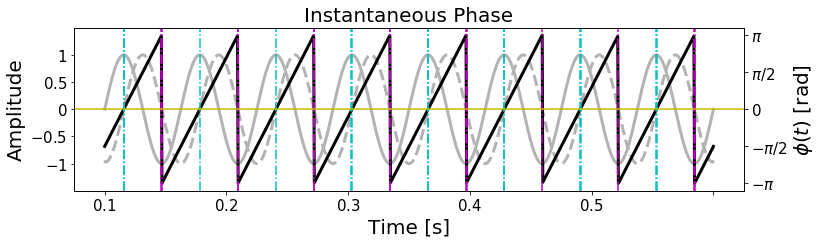

In [7]:
from scipy import signal

fs_pha_title = 20
fs_pha_label = 20
fs_pha_ticks = 15
t1 = np.linspace(0, 0.5, 1000)
x = np.sin(2 * np.pi * 16 * t1)
xa = signal.hilbert(x)

# Prepare for plots
fig, ax1 = plt.subplots(figsize=(12, 3))
ax2 = ax1.twinx()

# Plot data
ax1.plot(t1, xa.real, c=(.7,.7,.7), lw=3, ls='-')
ax1.plot(t1, xa.imag, c=(.7,.7,.7), lw=3, ls='--')
ax2.plot(t1, np.angle(xa), c='k', lw=3)

# Indication Lines
[ax2.axvline(tmp, c='c', ls='-.') for tmp in t1[xa.real>=0.999]]
[ax2.axvline(tmp, c='m', ls='-.') for tmp in t1[xa.real<=-0.999]]
ax2.axhline(0, c='y')

# Axes Properties
ax1.set_ylim([-1.5,1.5])
ax1.set_ylabel('Amplitude', fontsize=fs_pha_label)
ax1.set_yticks([-1, -.5, 0, .5, 1])
ax1.set_yticklabels(['$-1$', '$-0.5$', '$0$', '$0.5$', '$1$'], fontsize=fs_pha_ticks)

ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax2.set_yticklabels(['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$'], fontsize=fs_pha_ticks)
ax2.set_ylabel('$\phi(t)$ [rad]', fontsize=fs_pha_label)

ax1.set_xticklabels(['$0.0$', '$0.1$', '$0.2$', '$0.3$', '$0.4$', '$0.5$'], fontsize=fs_pha_ticks)
ax1.set_xlabel('Time [s]', fontsize=fs_pha_label)

# Title
ax1.set_title('Instantaneous Phase', fontsize=fs_pha_title)

<a id=references></a>
# References

<a id=ref1></a>
[1] A. B. L. Tort et al., “Measuring phase-amplitude coupling between neuronal oscillations of different frequencies,” J. Neurophysiol., vol. 104, no. 2, pp. 1195–1210, 2010. Available: http://jn.physiology.org/content/104/2/1195.

<a id=ref2></a>
[2] Brain Storm, "Phase-Amplitude Coupling." http://neuroimage.usc.edu/brainstorm/Tutorials/TutPac.

<a id=ref3></a>
[3] B. Pittman-Polletta, W.-H. Hsieh, S. Kaur, M.-T. Lo, and K. Hu, “Detecting phase-amplitude coupling with high frequency resolution using adaptive decompositions,” J. Neurosci. Methods, vol. 226, pp. 15–32, 2014. Available: http://www.sciencedirect.com/science/article/pii/S016502701400017X?via%3Dihub
